# Generation and animation of chaotic attractors

This notebook finds and animates equations governing systems of differential equations called [chaotic attractors](https://en.wikipedia.org/wiki/Attractor). Sample outputs can be found in the output folder.

### Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation
import math

### Helper functions

In [4]:
def quadratic_map(x, y, z, params, dt=0.0005):
    '''
    Given coordinates and a tuple of coefficients for each differential equation, compute and return 
    one simulated timestep of movement.
    '''
    quad_coeffs = [x, x**2, y, y**2, z, z**2, x*y, x*z, y*z, 1]
    alpha, beta, gamma = params
    
    dx = np.dot(quad_coeffs, alpha)
    dy = np.dot(quad_coeffs, beta)
    dz = np.dot(quad_coeffs, gamma)
    
    return x+(dx*dt), y+(dy*dt), z+(dz*dt)

In [5]:
def compute_camera(num, scaling_factor=0.75):
    '''
    Compute and return the angle and elevation of the camera for a given timestep
    '''
    angle = (num*scaling_factor)%360
    ele = 2*np.sin(angle*math.pi/180)+10
    
    return (angle, ele)

In [6]:
def gen_rand_color():
    '''
    Generate random color for visualization
    '''
    #pinkish color
    r = 0.75+np.random.uniform(-0.1,0.1)
    g = 0.2+np.random.uniform(-0.2,0.2)
    b = np.random.uniform(0.5,0.7)
    a = np.random.uniform(0.3,0.8)
    
    l_color = [r,g,b,a]
    
    return l_color

In [7]:
def gen_random_coeffs(low=-1.0, high=1.0):
    '''
    Given a min and max value, randomly generate and return a tuple of coefficients for x, y, and z.
    '''
    alpha = np.random.uniform(size=(10,), low=low, high=high)
    beta = np.random.uniform(size=(10,), low=low, high=high)
    gamma = np.random.uniform(size=(10,), low=low, high=high)
    
    return (alpha, beta, gamma)

In [13]:
def compute_distances(data, cutoff=100):
    '''
    Find and return the distances of each point in data from the origin between t=0 and t=cutoff
    '''
    dists = []
    
    for dat in data[0:cutoff]:
        
        transposed = dat.transpose()
        current_dists = [np.linalg.norm(transposed[i,:]) for i in range(len(transposed))]
        
        dists.append(current_dists)
            
    return dists

In [14]:
def gen_lorenz(length, params=None, dims=3, init_spread=10.0):
    '''
    Generate and return the position of a particle given a number of timesteps and a set of equations.
    '''
    line_data = np.empty((dims, length))
    line_data[:, 0] = np.random.normal(size=(dims,), scale=init_spread)
    
    for index in range(1, length):
        
        x, y, z = line_data[:,index-1]
        x_prime, y_prime, z_prime = quadratic_map(x, y, z, params)
        
        line_data[:, index] = (x_prime, y_prime, z_prime)

    return line_data


def update_lines(num, dataLines, lines, window=150):
    '''
    Plot particles in a system with a tail. Window specifies how long the tail of each particle is
    '''
    for line, data in zip(lines, dataLines):
        
        angle, ele = compute_camera(num)
        ax.view_init(elev=ele, azim=angle)
        
        if num>window:
            start = num-window
        else:
            start=0
            
        line.set_data(data[0:2, start:num])
        line.set_3d_properties(data[2, start:num])
        
    return lines


### Actually find the chaotic attractor

In [15]:
def gen_data(num_frames, num_gen, seed=None, dims=3, eps=1e4):
    '''
    Find and return the random seed and corresponding simulated data for our novel strange attractor
    '''
    diverges = True
    
    if seed == None:
        seed = np.random.randint(0,1e7)
    
    while diverges:
        print(f'trying seed = {seed}')
        np.random.seed(seed)
        
        params = gen_random_coeffs()
        
        # you can tell a sim diverges far before the last frame, so for identifying divergent systems we
        # don't need to simulate the whole way through
        
        sim_count = 500
        gen_count = int(num_gen/3)
        
        if num_frames < sim_count:
            sim_count = num_frames
            
        data = [gen_lorenz(sim_count, params, dims) for _ in range(gen_count)]
        dists = compute_distances(data, cutoff=sim_count)
        
        if np.max(dists) <= eps:
            diverges = False
        else:
            seed = np.random.randint(0,1e7)
            
            print(f'max_dist = {np.nanmax(dists)}')
            print(f'sim reaches max dist at t = {np.min(np.where(np.max(dists, axis=0) == np.nanmax(dists))[0])}\n')
    
    print(f'found coefficients which dont diverge, max_dist = {np.max(dists)}')
    #now we generate the full simulation
    data = [gen_lorenz(num_frames, params, dims) for _ in range(num_gen)]
    
    return (seed,data)

### Animate our chaotic attractor

Be warned, this method isn't very efficient, and actually finding good coefficients can take a while

<ipython-input-17-c9f859a36b56>:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)


trying seed = 6066554
found coefficients which dont diverge, max_dist = 2742.7316992289025
rendering frames...
scale=71.8882383597481
finished animating attractor with seed = 6066554


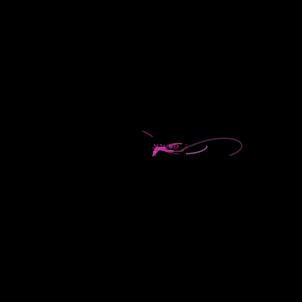

In [17]:
fig = plt.figure()
ax = p3.Axes3D(fig)
plt.style.use('dark_background')

lines = []
num_frames = 1000
num_gen = 200
window = 100

seed, data = gen_data(num_frames, num_gen, seed=6066554)

dists = compute_distances(data, cutoff=num_frames)

color_seed = np.random.randint(0,1e5)

for dat in data:
    
    np.random.seed(color_seed)
        
    l_color = gen_rand_color()
    l = ax.plot(dat[0, 0], dat[1, 0], dat[2, 0], color=l_color)[0]
    
    lines.append(l)
    
    color_seed +=1
    
#axes bound by 2 std dev above mean distance across the entire sim
dists = np.clip(dists, -1e20, 1e20)
scale=np.clip(np.nanmean(dists)+2*np.nanstd(dists), 0, 200)

#set proper scale for each axis
ax.set_xlim3d([-scale, scale])
ax.set_ylim3d([-scale, scale])
ax.set_zlim3d([-scale, scale])

plt.axis('off')
print('rendering frames...')
print(f'scale={scale}')
# Creating the Animation object
line_ani = animation.FuncAnimation(fig, update_lines, frames=num_frames, fargs=(data, lines, window),
                                   interval=30, blit=True)
line_ani.save(f'output/lorenz{seed}.gif', writer='pillow')
print(f'finished animating attractor with seed = {seed}')